# Shape completion of partial pointclouds - A transformer based autoencoder model

This notebook demonstrates how to *setup your own transformer model* for *shape completion of impartial pointclouds*, in this example we focus on ribs.<br>
After setting up the environment and importing the required libraries, we *search the MedShapeNet database.*<br>
Then we *download the shapes (STLs of ribs) from the MedShapeNet database* and *convert these to pointclouds (PLY)*.<br>
The *data augmentation* consists of *moving the point clouds to the origin* and *normalizing the point clouds*. <br>
Then we *create partial pointclouds* i.e, remove a part of the *ground truth* to serve as *input for training*, the GT and training output are inspected and visualized. <br>
A *transformer* model tailored for pointclouds is setup using the classical *encoder* and *decoder*.<br>
After training the model using the Chamfer Distance Loss and Adam Optimizer, we load the weights, download unseen inputs and run inference. <br>
An example result is plotted.

## Tested on
- Windows 11, VScode (Jupyter Notebook), GeForce RTX 3050, (CUDA 12.3 - guess not important), environment below.
- A node of the Work Cluster (IKIM - Essen -> KITE project): Dockerized/Kubernetes environment CPU: min(8) max(32), Memory Gi min(16) max(128), GPU: single NVIDIA MIG 20GB.

## Steps (do step 1 manually)
1. Create the virtual environment and activate it within this notebook.
    - conda create -n your_env python=3.10 ipykernel.
    - Select the env for this ipynb (in vscode the upper right corner 'select kernel' or cntrl+p >python:select interpreter).
2. Install additional requirements in the environment.
3. Import the needed libraries.
4. Search and download x shapes from the MedShapeNet database, then convert them to pointclouds.
5. Data augmentation to make incomplete pointclouds based on the previously generated pointclouds (ground truth) and preprocess them for input for the Machine Learning model.
6. Plot example of ground truth and input for the model for visual inspection.
7. Create the transformer based auto encoder-decoder model.
8. Training of the model using the chamfer distance  loss and Adam optimizer.
9. Load the weights, prepare new inference input, run inference and plot the result
<br><br>
10. Remove the environment: conda remove --name your_env --all


# Step 2 & 3 (PIP installs and Imports)

In [1]:
# install additional requirements
# Note do manually: conda create -n your_env python=3.10 ipykernel # then activate the kernel in the jypnb

# medshapenet to interact with the database
!pip install MedShapeNet

# For plotting interactive 3D plots
!pip install plotly==5.24.1

# Tensorflow is used for the setup and training of the model
!pip install tensorflow-graphics==2021.12.3

# Used to plot and save the history of the training of the model
!pip install plot-keras-history==1.1.36

# Install specific versions of keras and tensorflow to avoid the error 'NotImplementedError: Exception encountered when calling Lambda.call().'
!pip install keras==2.15.0 tensorflow==2.15.0

# for plotting last step
!pip install nbformat==5.10.4


  Using cached MedShapeNet-0.1.21-py3-none-any.whl.metadata (5.6 kB)
  Using cached minio-7.2.9-py3-none-any.whl.metadata (6.5 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached numpy-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached numpy_stl-3.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached fire-0.6.0-py2.py3-none-any.whl
  Using cached trimesh-4.4.9-py3-none-any.whl.metadata (18 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached pycryptodome-3.20.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached python_utils-3.9.0-py2.py3-none-any.whl.metadata (9.8 kB)
  Using cached

In [1]:
# Imports

# Working with numpy arrays, usefull for 3D shapes and machine learning (tensorflow)
import numpy as np

# Machine learning libraries for model architecture
from tensorflow.keras import Input
from tensorflow.keras import layers as L
from tensorflow.keras import models as M
import tensorflow as tf
# Get checkpoints
from tensorflow.keras.callbacks import ModelCheckpoint

# For training of the model (because of the chamfer distance)
import tensorflow_graphics as tfg
from tensorflow_graphics.nn.loss import chamfer_distance

# For the optimizer
from tensorflow.keras.optimizers import Adam 

# For system operations
import os
import glob
from pathlib import Path
import shutil

# For progress bar
from tqdm import tqdm

# For transforming the stl (vertice/faces) to ply (pointclouds)
import trimesh

# For plotting the results
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plot_keras_history import plot_history

# To sample a subset from our database search
from random import sample

# Connection with database MedShapeNet
from MedShapeNet import MedShapeNet as msn
from MedShapeNet import Transformations


2024-09-29 17:19:04.128778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 17:19:04.132034: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 17:19:04.176199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 17:19:04.176223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 17:19:04.177829: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to


        This message only displays once when importing MedShapeNet for the first time.

        MedShapeNet API is under construction, more functionality will come soon!

        For information use MedShapeNet.msn_help().
        Alternatively, check the GitHub Page: https://github.com/GLARKI/MedShapeNet2.0

        PLEASE CITE US If you used MedShapeNet API for your (research) project:
        
        @article{li2023medshapenet,
        title={MedShapeNet--A Large-Scale Dataset of 3D Medical Shapes for Computer Vision},
        author={Li, Jianning and Pepe, Antonio and Gsaxner, Christina and Luijten, Gijs and Jin, Yuan and Ambigapathy, Narmada, and others},
        journal={arXiv preprint arXiv:2308.16139},
        year={2023}
        }

        PLEASE USE the def dataset_info(self, bucket_name: str) to find the proper citation alongside MedShapeNet when utilizing a dataset for your resarch project.
        


# Step 4 (Search, download and convert x shapes from the MedShapeNet Database.)

In [3]:
# Search the database for ribs
list_urls_ribs = msn.search_by_name(name="rib", print_output=False)

# for inspection store result in a txt
with open('found_download_urls_for_rib.txt', 'w') as f:
    for rib in list_urls_ribs:
        f.write(rib + "\n")

# we only want ribs and not ribcartilage, so we improve the search term
list_urls_ribs = msn.search_by_name(name="rib_", print_output=False)
print('Number of found ribs within the MedShapeNet database: ', len(list_urls_ribs))

Number of found ribs within the MedShapeNet database:  17651


In [4]:
# Download x shapes

# For demonstration purposes we sample 1500 ribs from the database
rib_urls_sample = sample(list_urls_ribs, 1500)

# Download the sampled ribs using search_by_name_and_download
msn_instance = msn()
failed_downloads = msn_instance.search_and_download_by_name(name="rib_", print_output=True, sample_size = 1500)


Connection to MinIO server timed out after 5 seconds.
Download directory created at: /home/jovyan/PointCloudCompletor/msn_downloads
Starting download of 1500 files for search 'rib_'...


Download complete! Files are stored in folder: msn_downloads/rib__stl
0 downloads failed.


In [6]:
# Convert STL to PLY (shapes -> pointclouds)

# Use MedShapeNet and transformation class
msn_instance = msn()
msn_transform_instance = Transformations()

# Define the input dir (where stl files are stored) and output dir (where ply files will be stored) 
convert_dir = msn_instance.download_dir / Path('rib__stl')
output_dir = msn_instance.download_dir / Path('rib__ply')

# convert all STL files to pointcloud files
failed_conversions = msn_transform_instance.dataset_stl_to_pointcloud(input_dir=convert_dir, output_dir=output_dir , print_output=False, num_of_points=6144)

# print output
print(f"Conversion of stl to ply done; {len(failed_conversions)} conversions failed; Poinclouds are stored in: {output_dir}")

if failed_conversions:
    print(f"These are the files with failed conversion:\n{failed_conversions}")

Converting STL to PLY: 100%|██████████| 1500/1500 [04:57<00:00,  5.05it/s]

Conversion of stl to ply done; 0 conversions failed; Poinclouds are stored in: msn_downloads/rib__ply


# Step 5 (Data augmentation and preprocessing)
- The pointclouds (PLY) are converted to ground truth and input data for training:
    1. Converted to numpy arrays.
    2. Centred around the mean.
    3. A part of the pointcloud is removed to serve as input data.

In [2]:
# Data augmentation (methods only)

# Function normalize poin cloud so it can be used as input for our diffusion model.
def normalize_point_cloud(point_cloud):
    # Compute the mean of the point cloud
    mean = np.mean(point_cloud, axis=0)

    # Subtract the mean to move the point cloud to the origin
    point_cloud -= mean

    # Compute the maximum distance (of a point) from the origin
    max_distance = np.max(np.sqrt(np.sum(point_cloud**2, axis=1)))

    # Scale the distances to the range -1.0 and 1.0 (unit sphere)
    point_cloud /= max_distance

    return point_cloud

# Remove a part of the mesh so we have incomplete meshes ................................................................why knn?
def remove_knn_points_by_index(points, point_index, num_remove):
    """
    Remove the nearest points to the point at the given index using KNN.

    Args:
    points (np.ndarray): Original point cloud (N, D).
    point_index (int): Index of the reference point (0 <= point_index < N).
    num_remove (int): Number of points to remove.

    Returns:
    np.ndarray: Point cloud with points removed (N - num_remove, D).
    """
    # determine centre point
    center_point = points[point_index]

    # compute euclidean distance between each point and the center_point
    distances = np.linalg.norm(points - center_point, axis=1)

    # Find the indices of the x (num_remove) points nearest to the center_point
    knn_indices = np.argsort(distances)[:num_remove]

    # Remove these points from the point cloud to make partial models for training
    remaining_points = np.delete(points, knn_indices, axis=0)

    return remaining_points

# Preprocess the data for the training
def preprocess_data(root_folder):
    # list of shapes for the diffusion model (input and ground truth)
    input_set = []
    GT_set = []

    # If you have multiple anatomy, or per side of the rib, you want to find a way to handle classes. Out of scope for this example, but as a showcase.
    labels =[]

    # Search recursively for .ply files in root_folder
    root_folder = Path(root_folder)

    # Recursively search for all .ply files in the root_folder
    for ply_file in root_folder.rglob('*.ply'):

        try:
            # Create additional labels/classes - outside the scope of this example but can be used for larger models with multiple classes
            relevant_parts = ply_file.stem.split('_')
            labels.append((relevant_parts[1], relevant_parts[2], relevant_parts[3].split('.')[0]))
        except:
            labels.append((ply_file.stem))
            print("filename instead of labels appended to labels")

        # load the (ply) mesh
        mesh = trimesh.load(ply_file)

        # create the normalized groundt truth for the diffusion model
        GT = normalize_point_cloud(np.array(mesh.vertices))

        # Create partial cloud by removing knn points (1/3th) of original 6144
        idx = 0
        partial_cloud = remove_knn_points_by_index(GT, idx, 2048)

        # append partial cloud to input_set
        input_set.append(partial_cloud)

        # append GT to GT_set
        GT_set.append(GT)

        # If you want to make multiple input data with a single GT you can use fsample
        # idxs= [0, 1000, 2000, 3000]
        # import fsample # make sure to !pip install fsample
        # indices = fpsample.fps_sampling(GT, 1, start_idx=0)
        # for idx in indices:
        #   partial_cloud = remove_knn_points_by_index(GT, idx, 2048)
        #   input_set.append(partial_cloud)
        #   GT_set.append(GT)

    return np.array(input_set), np.array(GT_set), labels


In [3]:
# Run the data augmentation and preprocessing

# NOTE: only needed if previous function was not executed
msn_instance = msn() 

# Define the datadirectory of the pointclouds
ply_dir = Path(msn_instance.download_dir) / Path('rib__ply')

# create the input for the model (partial point clouds), the GT (ground truth) and the labels
inputs, GT, labels = preprocess_data(ply_dir)

# Inspect input, output and GT
print('\n')
# Print number of input point clouds and their shape
print(f"Number of input point clouds: {len(inputs)}")
print(f"Shape of the input point cloud (n, x, y, z): {inputs[0].shape}\n")
# Print number of ground truth point clouds and their shape
print(f"Number of ground truth point clouds: {len(GT)}")
print(f"Shape of the ground truth point cloud (n, x, y, z): {GT[0].shape}\n")
# Print number of classes and an example class name
print(f"Length of classes matching the GT/Input point clouds: {len(labels)}")
print(f"Example of class info for a point cloud: {labels[0]}\n")
# Print the type and shape of the GT/Input and show a sample of the vertices
print(f'Type of GT/input: {type(GT[0])}, with shape: {GT[0].shape}, and example of vertice (xyz): {GT[0][0]}')

Connection to MinIO server timed out after 5 seconds.
Download directory already exists at: /home/jovyan/PointCloudCompletor/msn_downloads


Number of input point clouds: 1500
Shape of the input point cloud (n, x, y, z): (4096, 3)

Number of ground truth point clouds: 1500
Shape of the ground truth point cloud (n, x, y, z): (6144, 3)

Length of classes matching the GT/Input point clouds: 1500
Example of class info for a point cloud: ('rib', 'right', '6')

Type of GT/input: <class 'numpy.ndarray'>, with shape: (6144, 3), and example of vertice (xyz): [-0.14383439 -0.64451465  0.35897715]


# Step 6 (Plot example of  Ground Truth and input of the model)

('rib', 'left', '3')


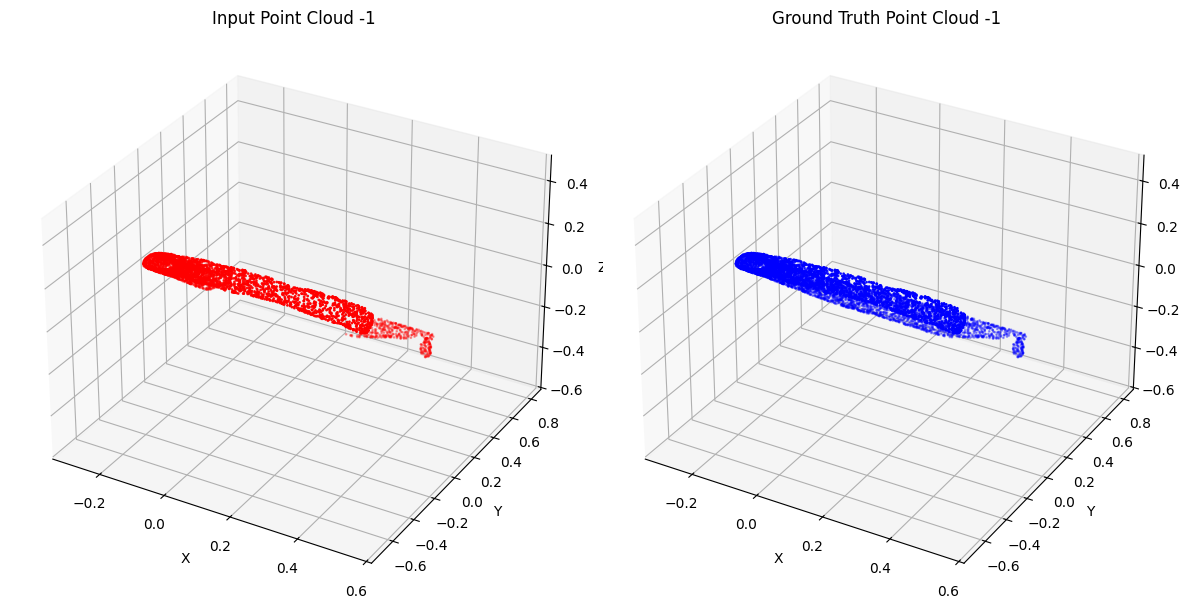

In [4]:
def plot_point_clouds(inputs, GT, index=0):
    """
    Plot two point clouds side by side for comparison.

    Args:
    - inputs: List of input point clouds.
    - GT: List of ground truth point clouds.
    - index: Index of the point clouds to plot.
    """
    # Ensure the index is within the range of the inputs and GT
    if index <= -len(inputs) or index >= len(inputs) or index >= len(GT):
        raise ValueError("Index out of range for inputs or GT.")
    
    # Create a 3D plot
    fig = plt.figure(figsize=(12, 6))

    # Plot the input point cloud
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(inputs[index][:, 0], inputs[index][:, 1], inputs[index][:, 2], c='r', s=1)
    ax1.set_title(f'Input Point Cloud {index}')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot the ground truth point cloud
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(GT[index][:, 0], GT[index][:, 1], GT[index][:, 2], c='b', s=1)
    ax2.set_title(f'Ground Truth Point Cloud {index}')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.tight_layout()
    plt.show()

# Example usage:
print(labels[-1])
plot_point_clouds(inputs, GT, index=-1)  # Change index as needed to visualize different clouds


In [4]:
def plot_point_cloud(points_list, titles):
    """
    Plot multiple point clouds in separate figures.

    Args:
    - points_list: List of point clouds (input and ground truth).
    - titles: List of titles for each point cloud figure.
    """
    for points, title in zip(points_list, titles):
        fig = go.Figure()
        fig.add_trace(go.Scatter3d(
            x=points[:, 0],
            y=points[:, 1],
            z=points[:, 2],
            mode='markers',
            marker=dict(size=2, opacity=0.8, color='red' if 'Input' in title else 'blue'),
            name=title
        ))
        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z'
            ),
            showlegend=True
        )
        fig.show()

# Example usage
print(labels[-1])
plot_point_cloud([inputs[-1], GT[-1]], ['Input Point Cloud', 'Ground Truth Point Cloud'])


('rib', 'left', '3')


# Step 7: Create the transformer based auto encoder-decoder model

In [5]:
# Methods to make the encoder and decoder model

# For the PCT Encoder and Decoder
def LayerLinBnRelu(tensor, C, seq_name, use_bias=True, activation=None, LeakyAlpha=0.0):
    """
    Create a linear layer followed by a batch normalization and a ReLU activation (or Leaky ReLU).

    :param tensor: Input tensor to the layer.
    :param C: Number of output units in the linear layer.
    :param seq_name: A string name for the layer sequence (used for naming).
    :param use_bias: Boolean indicating whether to use a bias term in the linear layer (default is True).
    :param activation: Activation function to be applied to the linear layer output (default is None).
    :param LeakyAlpha: Slope of the Leaky ReLU activation; if 0, standard ReLU is used (default is 0.0).
    :return: The output tensor after applying the linear layer, batch normalization, and activation function.
    """
    
    # Create an input layer with the shape of the provided tensor, and give it a unique name
    x_in = Input(shape=tensor.shape[1:], name=seq_name + '_input')
    
    # Apply a linear transformation (Dense layer) to the input tensor
    # C specifies the number of output units, use_bias determines if a bias term should be used
    x = L.Dense(C, use_bias=use_bias, activation=activation, name=seq_name + '_lin')(x_in)
    
    # Choose the activation function based on the LeakyAlpha parameter
    if LeakyAlpha == 0.0:
        # Standard ReLU activation
        x_out = L.ReLU(name=seq_name + '_ReLU')(x)
    else:
        # use Leaky ReLU activation with the specified alpha
        x_out = L.LeakyReLU(alpha=LeakyAlpha, name=seq_name + '_ReLU')(x)

    # Create a Keras model with the specified input and output
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    
    # Return the output of the model applied to the input tensor
    return model(tensor)

#########################################################

# For the PCT Encoder

# A custom Keras layer to uniformly sample a fixed number of points from the input point cloud.
class UniformSampler(tf.keras.layers.Layer):
    def __init__(self, num_points, seed=42, **kwargs):
        super(UniformSampler, self).__init__(**kwargs)
        self.num_points = num_points  # The number of points to sample from the input.
        self.seed = seed  # Random seed for reproducibility.

    def build(self, input_shape):
        pass  # No additional weights are needed for this layer.

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]  # Get the batch size of the input tensor.
        data_size = tf.shape(inputs)[1]  # The number of points in each sample.
        
        # Randomly sample indices from the input data.
        indices = tf.random.uniform(
            shape=(batch_size, self.num_points),
            minval=0,
            maxval=data_size,
            dtype=tf.int32,
            seed=self.seed
        )
        # Return the sampled point indices.
        return indices  

    def compute_output_shape(self, input_shape):
        # Output shape will have 'num_points' for each batch, along with feature dimensions.
        return (input_shape[0], self.num_points, input_shape[2])

    def get_config(self):
        # Save the configuration to reconstruct the layer.
        config = super(UniformSampler, self).get_config()
        config.update({
            "num_points": self.num_points,
            "seed": self.seed
        })
        return config

    
# Computes pairwise Euclidean distance between two sets of 3D points.
def pairwise_distance(xyz1, xyz2):
    n = xyz1.shape[1]  # Number of points in the first set.
    c = xyz1.shape[2]  # Number of channels/features per point.
    m = xyz2.shape[1]  # Number of points in the second set.
    
    # Reshape and tile xyz1 and xyz2 for broadcasting.
    xyz1 = tf.tile(tf.reshape(xyz1, (-1, 1, n, c)), [1, m, 1, 1])
    xyz2 = tf.tile(tf.reshape(xyz2, (-1, m, 1, c)), [1, 1, n, 1])
    
    # Compute pairwise squared distances.
    dist = tf.reduce_sum((xyz1 - xyz2) ** 2, -1)
    return dist

# Finds the K-nearest neighbors in 'xyz2' for each point in 'xyz1'.
def knn_point(k, xyz1, xyz2):
    dist = -pairwise_distance(xyz1, xyz2)  # Compute negative distance for top-k sorting.
    val, idx = tf.math.top_k(dist, k)  # Get top-k closest points and their indices.
    return -val, idx  # Return the actual distances (negated back) and the indices.

# Samples points using FPS (farthest point sampling) and groups their neighboring points.
def sample_and_group(args, nsample):
    xyz, pts, fps_idx = args  # Extract input arguments: coordinates, features, and FPS indices.
    
    # Gather the new center points using the FPS indices.
    new_xyz = tf.gather_nd(xyz, tf.expand_dims(fps_idx, -1), batch_dims=1)
    new_pts = tf.gather_nd(pts, tf.expand_dims(fps_idx, -1), batch_dims=1)
    
    # Find the K-nearest neighbors for each new center point.
    _, idx = knn_point(nsample, xyz, new_xyz)
    
    # Gather the neighboring points and compute relative coordinates.
    grouped_pts = tf.gather_nd(pts, tf.expand_dims(idx, -1), batch_dims=1)
    grouped_pts -= tf.tile(tf.expand_dims(new_pts, 2), (1, 1, nsample, 1))
    
    # Concatenate the original and grouped points to create new features.
    new_pts = tf.concat([grouped_pts, tf.tile(tf.expand_dims(new_pts, 2), (1, 1, nsample, 1))], axis=-1)
    
    return new_xyz, new_pts  # Return the new center points and their corresponding grouped features.

# Implements a self-attention layer for point cloud data.
def LayerSelfAttention(tensor, seq_name):
    x_in = Input(shape=tensor.shape[1:], name=seq_name + '_input')  # Create input layer.
    C = x_in.shape[2]  # The number of features per point.
    
    # Create weight matrices for query, key, and value projections.
    W_q = L.Dense(C // 4, use_bias=False, activation=None, name=seq_name + '_Q')
    W_k = L.Dense(C // 4, use_bias=False, activation=None, name=seq_name + '_K')
    W_v = L.Dense(C, use_bias=False, activation=None, name=seq_name + '_V')
    
    # Compute query and key projections.
    x_q = W_q(x_in)
    x_k = W_k(x_in)
    
    # Use the same weights for key and query (shared weights in attention).
    W_k.set_weights(W_q.get_weights())
    
    # Transpose the key matrix for the dot product.
    x_k = L.Lambda(lambda t: tf.transpose(t, perm=(0, 2, 1)), name=seq_name + '_KT')(x_k)
    
    # Compute value projection.
    x_v = W_v(x_in)
    
    # Compute attention weights using the dot product of queries and keys.
    energy = L.Lambda(lambda ts: tf.matmul(ts[0], ts[1]), name=seq_name + '_matmul1')([x_q, x_k])
    attention = L.Softmax(axis=1, name=seq_name + '_softmax')(energy)
    
    # Normalize the attention weights.
    attention = L.Lambda(lambda t: t / (1e-9 + tf.reduce_sum(t, axis=2, keepdims=True)), name=seq_name + '_l1norm')(attention)
    
    # Compute the result of the attention operation.
    x_r = L.Lambda(lambda ts: tf.matmul(ts[0], ts[1]), name=seq_name + '_matmul2')([attention, x_v])
    
    # Subtract the attention result from the original input (residual connection).
    x_r = L.Lambda(lambda ts: tf.subtract(ts[0], ts[1]), name=seq_name + '_subtract')([x_in, x_r])
    
    # Apply a linear layer with batch normalization and ReLU.
    x_r = LayerLinBnRelu(x_r, C, seq_name + '_LBR', use_bias=True)
    
    # Add the result back to the original input (residual connection).
    x_out = L.Lambda(lambda ts: tf.add(ts[0], ts[1]), name=seq_name + '_add')([x_in, x_r])
    
    # Return the output of the attention layer.
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    return model(tensor)

# Defines the Point Cloud Transformer (PCT) encoder.
def PCT_encoder(xyz):
    # First linear layer: Apply a fully connected (dense) layer, followed by batch normalization and ReLU.
    # This increases the feature dimension to 64.
    x = LayerLinBnRelu(xyz, 64, 'E-IN_LBR1', use_bias=False)
    
    # Second linear layer: Increase the feature dimension further to 128.
    x = LayerLinBnRelu(x, 128, 'E-IN_LBR2', use_bias=False)
    
    # Sample 4096 points using a uniform sampling strategy (such as Farthest Point Sampling).
    # `fps_idx` contains the indices of the 4096 sampled points.
    fps_idx = UniformSampler(4096)(xyz)
    
    # Group the points based on their proximity to the sampled points.
    # `sample_and_group` creates local point neighborhoods by selecting `nsample=32` neighbors for each sampled point.
    # `new_xyz` is the reduced set of points, and `new_feature` contains the aggregated features of the neighborhoods.
    new_xyz, new_feature = L.Lambda(sample_and_group, arguments={'nsample': 32}, name='E-SG1')([xyz, x, fps_idx])
    
    # Apply another linear layer with batch normalization and ReLU, followed by max pooling.
    # This increases the feature dimension to 512, and the max-pooling operation reduces the dimensionality along the neighborhood axis.
    x = LayerLinBnRelu(new_feature, 512, 'E-SG1_LBR1', use_bias=False)
    x = L.Lambda(lambda t: tf.reduce_max(t, axis=2), name='E-SG1_MaxPool')(x)
    
    # Repeat the sampling and grouping process, but this time sample 2048 points.
    # `fps_idx` contains the indices of the sampled 2048 points.
    fps_idx = UniformSampler(2048)(new_xyz)
    
    # Group and aggregate features similarly to the previous step.
    new_xyz, new_feature = L.Lambda(sample_and_group, arguments={'nsample': 32}, name='E-SG2')([new_xyz, x, fps_idx])
    
    # Apply another linear layer and max pooling. This increases the feature dimension to 1024.
    x = LayerLinBnRelu(new_feature, 1024, 'E-SG2_LBR1', use_bias=False)
    x = L.Lambda(lambda t: tf.reduce_max(t, axis=2), name='E-SG2_MaxPool')(x)
    
    # Apply a series of self-attention layers to capture global relationships between points.
    # Self-attention layers allow the model to focus on different parts of the point cloud for feature extraction.
    x1 = LayerSelfAttention(x, 'E-SA1')
    x2 = LayerSelfAttention(x1, 'E-SA2')
    x3 = LayerSelfAttention(x2, 'E-SA3')
    x4 = LayerSelfAttention(x3, 'E-SA4')
    
    # Concatenate the output of the four self-attention layers.
    # `x0` contains the concatenated feature vectors from each attention layer.
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-SA_Concat')([x1, x2, x3, x4])
    
    # Concatenate the original features (before attention) with the new concatenated features from attention layers.
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-OUT_Concat')([x0, x])
    
    # Apply another linear layer with batch normalization and LeakyReLU activation. This increases the feature dimension to 2048.
    x = LayerLinBnRelu(x, 2048, 'E-OUT_LBR', use_bias=False, LeakyAlpha=0.2)
    
    # Apply another set of self-attention layers to capture additional global features.
    x1 = LayerSelfAttention(x, 'E-SA5')
    x2 = LayerSelfAttention(x1, 'E-SA6')
    x3 = LayerSelfAttention(x2, 'E-SA7')
    x4 = LayerSelfAttention(x3, 'E-SA8')
    
    # Concatenate the outputs of the four new self-attention layers.
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-SA_Concat2')([x1, x2, x3, x4])
    
    # Apply a final linear layer with batch normalization and LeakyReLU activation. This increases the feature dimension to 4096.
    x = LayerLinBnRelu(x0, 4096, 'E-OUT_LBR1', use_bias=False, LeakyAlpha=0.2)
    
    # Perform a global max pooling operation to reduce the feature map to a single global feature vector.
    # The resulting tensor has the shape `(batch_size, 1, 4096)`, containing 4096 global features for each point cloud in the batch.
    output_feats = L.Lambda(lambda t: tf.reduce_max(t, axis=1, keepdims=True), name='E-OUT_MaxPool')(x)
    
    # Return the global feature vector, which summarizes the input point cloud.
    return output_feats

#########################################################

# For the decoder

# Defines the Source-Target Attention Layer for cross-attention between the source (encoder) and target (decoder) sequences.
def LayerSrcTrgtAttention(args, seq_name):  # Cross-attention mechanism
    E_tensor, D_tensor = args  # E_tensor: Source features (from encoder), D_tensor: Target features (from decoder)
    
    # Define input layers for encoder and decoder tensors
    xE_in = Input(shape=E_tensor.shape[1:], name=seq_name+'_input-E')  # Encoder input
    C = xE_in.shape[2]  # Feature dimension of encoder tensor
    xD_in = Input(shape=D_tensor.shape[1:], name=seq_name+'_input-D')  # Decoder input
    out_dim = xD_in.shape[2]  # Feature dimension of decoder tensor

    # Define learnable projection matrices for query, key, and value (in cross-attention)
    W_q = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_Q')  # Query projection
    W_k = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_K')  # Key projection
    W_v = L.Dense(out_dim, use_bias=False, activation=None, name=seq_name+'_V')  # Value projection

    # Apply the projections to the decoder and encoder inputs
    x_q = W_q(xD_in)  # Project decoder input to queries
    x_k = W_k(xE_in)  # Project encoder input to keys
    x_k = L.Lambda(lambda t: tf.transpose(t, perm=(0,2,1)), name=seq_name+'_KT')(x_k)  # Transpose keys for attention
    x_v = W_v(xE_in)  # Project encoder input to values

    # Compute the attention scores as the dot product of queries and keys
    energy = L.Lambda(lambda ts: tf.matmul(ts[0], ts[1]), name=seq_name+'_matmul1')([x_q, x_k])
    
    # Apply softmax to obtain attention probabilities
    attention = L.Softmax(axis=1, name=seq_name+'_softmax')(energy)
    
    # Normalize the attention weights (L1 norm) across all keys
    attention = L.Lambda(lambda t: t / (1e-9 + tf.reduce_sum(t, axis=2, keepdims=True)), name=seq_name+'_l1norm')(attention)
    
    # Compute the weighted sum of the values using the attention scores
    x_r = L.Lambda(lambda ts: tf.matmul(ts[0], ts[1]), name=seq_name+'_matmul2')([attention, x_v])
    
    # Subtract the result from the decoder input (residual connection)
    x_r = L.Lambda(lambda ts: tf.subtract(ts[0], ts[1]), name=seq_name+'_subtract')([xD_in, x_r])
    
    # Apply a linear layer, batch normalization, and ReLU activation on the residual
    x_r = LayerLinBnRelu(x_r, out_dim, seq_name+'_LBR', use_bias=True)
    
    # Add the original decoder input back to the result (another residual connection)
    x_out = L.Lambda(lambda ts: tf.add(ts[0], ts[1]), name=seq_name+'_add')([xD_in, x_r])
    
    # Build and return the model, which processes the encoder and decoder tensors
    model = M.Model(inputs=[xE_in, xD_in], outputs=x_out, name=seq_name)
    return model([E_tensor, D_tensor])

def copy_and_mapping(tensor, nmul, seq_name):  # (learned) upsampling for pointclouds
    # Create an input layer with the shape of the tensor's dimensions except the batch size
    x_in = Input(shape=tensor.shape[1:], name=seq_name+'_input')  
    
    # Expand the dimensions of the input tensor by adding a new axis (dimension) at index 2
    x = L.Lambda(lambda t: tf.expand_dims(t, 2), name=seq_name+'_expand')(x_in)
    
    # Calculate the number of output channels by dividing the last dimension by nmul
    C = x.shape[-1] // nmul  
    
    # Apply a transposed convolution (deconvolution) to upsample the input tensor
    x1 = L.Conv2DTranspose(C, (1, nmul), (1, nmul), use_bias=True, activation=None, name=seq_name+'_convT')(x)
    
    # Apply a dense layer to the original input tensor
    x2 = L.Dense(C, use_bias=True, activation=None, name=seq_name+'_lin')(x)
    
    # Tile the output of the dense layer along the new dimension created earlier
    x2 = L.Lambda(lambda t: tf.tile(t, [1, 1, nmul, 1]), name=seq_name+'_tile')(x2)
    
    # Add the outputs from the transposed convolution and the tiled dense layer
    x = L.Lambda(lambda ts: tf.add(ts[0], ts[1]), name=seq_name+'_add')([x1, x2])
    
    # Calculate the total number of points by multiplying the dimensions of the output tensor
    npoint = x.shape[1] * x.shape[2]
    
    # Reshape the output tensor to merge the first two dimensions and maintain the last dimension
    x_out = L.Lambda(lambda t: tf.reshape(t, [-1, npoint, t.shape[3]]), name=seq_name+'_reshape')(x)
    
    # Create a model with the specified input and output, naming it according to seq_name
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    
    return model(tensor)  # Return the output of the model when the input tensor is passed


def pct_decoder(input_feats, input_eye_seed):  # Decoder function for point cloud transformer (PCT)
    # Replicate input features to match the desired output size (1024 points)
    m_feats = L.Lambda(lambda x: tf.tile(x, [1, 1024, 1]), name='D-IN_replicate')(input_feats)
    
    # Create a modified identity matrix by adding the seed (used for attention processing)
    input_eye = input_eye_seed + tf.eye(1024, 1024)
    
    # Initial dense layer for processing the eye matrix (no bias, no activation)
    x = L.Dense(4096 // 4, use_bias=False, activation=None, name='D1-IN')(input_eye)
    
    # Apply the source-target cross-attention mechanism (attention from the encoder to decoder features)
    x1 = LayerSrcTrgtAttention([m_feats, x], 'D-STA1')  # First attention layer
    x2 = LayerSrcTrgtAttention([m_feats, x1], 'D-STA2')  # Second attention layer
    x3 = LayerSrcTrgtAttention([m_feats, x2], 'D-STA3')  # Third attention layer
    x4 = LayerSrcTrgtAttention([m_feats, x3], 'D-STA4')  # Fourth attention layer
    
    # Concatenate the results of the attention layers along the feature dimension (axis=2)
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D1-STA_Concat')([x1, x2, x3, x4])
    
    # Concatenate the original input with the concatenated attention outputs
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D1-OUT_Concat')([x0, x])
    
    # Perform learned upsampling (increases point cloud resolution by a factor of 3)
    m_feats2 = copy_and_mapping(x, 3, 'D1-OUT_CopyAndMapping')
    
    # Create a new modified identity matrix for the next stage (now 3072 points)
    input_eye2 = input_eye_seed + tf.eye(3072, 3072)
    
    # Another dense layer for the second stage of attention processing
    x = L.Dense(1024 // 4, use_bias=False, activation=None, name='D2-IN')(input_eye2)
    
    # Second round of source-target attention (operating on upsampled features)
    x1 = LayerSrcTrgtAttention([m_feats2, x], 'D2-STA1')  # First attention layer in second stage
    x2 = LayerSrcTrgtAttention([m_feats2, x1], 'D2-STA2')  # Second attention layer
    x3 = LayerSrcTrgtAttention([m_feats2, x2], 'D2-STA3')  # Third attention layer
    x4 = LayerSrcTrgtAttention([m_feats2, x3], 'D2-STA4')  # Fourth attention layer
    
    # Concatenate the results from all the attention layers again (second stage)
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D2-STA_Concat')([x1, x2, x3, x4])
    
    # Concatenate the result with the previous input from this stage
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D2-OUT_Concat')([x0, x])
    
    # Perform another learned upsampling (increases point cloud resolution by a factor of 2)
    x = copy_and_mapping(x, 2, 'D2-OUT_CopyAndMapping')
    
    # Apply three successive layers of Linear, BatchNorm, and ReLU (learned transformations)
    x = LayerLinBnRelu(x, 128, 'D-OUT_LBR1', use_bias=False)  # First layer
    x = LayerLinBnRelu(x, 128, 'D-OUT_LBR2', use_bias=False)  # Second layer
    x = LayerLinBnRelu(x, 64, 'D-OUT_LBR3', use_bias=False, LeakyAlpha=0.2)  # Third layer with Leaky ReLU
    
    # Final dense layer to map the features to 3D points (no activation)
    output_points = L.Dense(3, activation=None, name='D-OUT_lin')(x)
    
    # Return the final output points (decoded point cloud)
    return output_points


### This is purely for the cluster setup, might be usefull for anyone on a GPU

In [6]:
bool_using_A100_cuda12_2 = True
if bool_using_A100_cuda12_2:
    # For working with our A100 please skip this

    import subprocess
    import sys

    # Check if GPU is available
    gpu_devices = tf.config.list_physical_devices('GPU')

    if gpu_devices:
        print("GPU available.")
        # Here you can include any additional configurations for GPU usage if necessary

        # Enable memory growth if GPU is available
        try:
            tf.config.experimental.set_memory_growth(gpu_devices[0], True)  
        except Exception as e:
            print(f"Could not set memory growth: {e}")
    else:
        print("No GPU found. Using CPU.")
        # !python3 -m pip install tensorflow[and-cuda]==2.17.0 # For the work cluster we have predifined docker env. for tensorflow (cuda 12.2)
        print("You can install tensorflow[and-cuda], check your versions! Then restart the kernel")


    # Check TensorFlow GPU/CPU status
    print("Physical devices:", tf.config.list_physical_devices())


No GPU found. Using CPU.
You can install tensorflow[and-cuda], check your versions! Then restart the kernel
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2024-09-29 17:20:35.719017: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Define the AutoEncoder function using PCT encoder and decoder
def AutoEncoder(num_input_points = 4096):
  eye_seed = Input(shape=(1, 1), name='input_eye_seed') # placeholder
  xyz = Input(shape=(num_input_points, 3), name='input_points') # placeholder
  encoded = PCT_encoder(xyz)
  output = pct_decoder(encoded, eye_seed)
  return M.Model(inputs = [xyz, eye_seed], outputs = output)

# Run/create the AutEncoder model
AE = AutoEncoder()

AE.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_points (InputLayer)   [(None, 4096, 3)]            0         []                            
                                                                                                  
 E-IN_LBR1 (Functional)      (None, 4096, 64)             192       ['input_points[0][0]']        
                                                                                                  
 E-IN_LBR2 (Functional)      (None, 4096, 128)            8192      ['E-IN_LBR1[0][0]']           
                                                                                                  
 uniform_sampler (UniformSa  (None, 4096)                 0         ['input_points[0][0]']        
 mpler)                                                                                       

# Step 8 (Training of the model using the chamfer distance  loss and Adam optimizer.)

In [8]:
def chamfer_distance_loss(y_true, y_pred):
    return tfg.nn.loss.chamfer_distance.evaluate(y_true, y_pred)

initial_lr = 1e-5
optimizer = Adam(learning_rate=initial_lr)
AE.compile(optimizer= optimizer, loss = chamfer_distance_loss)


In [9]:
# Directory to save the model weights
save_dir = Path('model_weights') 
save_dir.mkdir(parents=True, exist_ok=True)

# Define the ModelCheckpoint callback to save only the model weights
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'AE.h5'),  
    monitor='val_loss',               
    verbose=1,                         
    save_best_only=True,               
    save_weights_only=True,            
    mode='min'                         
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Metric to be monitored
    factor=0.9,            # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,             # Verbosity mode
    mode='auto',           # Mode: 'auto', 'min', or 'max'
    min_lr=1e-20         # Lower bound on the learning rate
)
def eye_seed(X):
    return tf.zeros([X.shape[0],1,1])


history = AE.fit([inputs,eye_seed(inputs)], GT, epochs=400, batch_size=1, validation_split = 0.2, shuffle=True, callbacks=[checkpoint_callback, reduce_lr])

# Output looks like:
'''
    Epoch 1/400
    1/1200 [..............................] - ETA: 11:45:23 - loss: 2.8581
    .
    .
    .

    .
    .
    .
    Epoch 400/400
    1200/1200 [..............................] - ETA: 11:45:23 - loss: e.g. 0.0001
'''

# Plot and save as image the History, i.e. each metric and validation metric of the model
# NOTE: Untested: Directly from documentation of plot_history (pip install plot-keras-history)
history_path = Path('history_model_singletons') 
save_dir.mkdir(parents=True, exist_ok=True)

plot_history(history, path=history_path, single_graphs=True)


Epoch 1/400
  77/1200 [>.............................] - ETA: 1:36:51 - loss: 0.2104

# Step 9 (Load the weights, prepare new inference input, run inference and plot the result)

In [11]:
# Load the model weights
path_weights = Path('model_weights') / Path('AE.h5') # NOTE: change to 'Path(Miccai_weights/AE3.h5)' to use your own trained weight instead of the pretrained weights.
AE.load_weights(path_weights)

In [12]:
# NOTE: These methods are used earlier in step 4 and 5 to create PLY and augment/preprocess the data respectively.
    # If you runned step 4 and 5, this is not needed.
    # These methods will be used to create input for inference

# Data augmentation (methods only)

# Function normalize poin cloud so it can be used as input for our diffusion model.
def normalize_point_cloud(point_cloud):
    mean = np.mean(point_cloud, axis=0)
    point_cloud -= mean
    max_distance = np.max(np.sqrt(np.sum(point_cloud**2, axis=1)))
    point_cloud /= max_distance
    return point_cloud

# Remove a part of the mesh so we have incomplete meshes as inference input
def remove_knn_points_by_index(points, point_index, num_remove):
    center_point = points[point_index]
    distances = np.linalg.norm(points - center_point, axis=1)
    knn_indices = np.argsort(distances)[:num_remove]
    remaining_points = np.delete(points, knn_indices, axis=0)
    return remaining_points

# Preprocess the data for the training
def preprocess_data(root_folder):
    input_set = []
    GT_set = []
    labels =[]
    root_folder = Path(root_folder)
    for ply_file in root_folder.rglob('*.ply'):
        try:
            relevant_parts = ply_file.stem.split('_')
            labels.append((relevant_parts[1], relevant_parts[2], relevant_parts[3].split('.')[0]))
        except:
            labels.append((ply_file.stem))
            print("filename instead of labels appended to labels")

        mesh = trimesh.load(ply_file)
        GT = normalize_point_cloud(np.array(mesh.vertices))
        idx = 0
        partial_cloud = remove_knn_points_by_index(GT, idx, 2048)
        input_set.append(partial_cloud)
        GT_set.append(GT)
    return np.array(input_set), np.array(GT_set), labels


In [17]:
# Download an input to test for inference

# NOTE: To create new inputs for inference you can also create partial clouds using Step 5 (Data augmentation and preprocessing) with another idx, e.g. 1000. 

# Setup MedShapeNet object for downloading.
msn_instance = msn()

# Define working directories
basepath = Path("inference")
input_inference_ply_dir = basepath / Path("input_ply")
input_inference_stl_dir = basepath / Path("input_stl")
download_dir = msn_instance.download_dir

# Create working directories
input_inference_ply_dir.mkdir(parents=True, exist_ok=True)
input_inference_stl_dir.mkdir(parents=True, exist_ok=True)

# Sample 5 STL files from MedShapeNet for inference
msn_instance.search_and_download_by_name(name="rib_", print_output=False, sample_size=5,save_folder=Path(input_inference_stl_dir))

# Check if stl file was already used for training
stl_files_in_inference = list(input_inference_stl_dir.glob("*.stl"))
for stl_file in stl_files_in_inference:
    filename = stl_file.name
    # Search for matching files recursively in download_dir and input dir
    matching_files = list(download_dir.rglob(filename)) 
    
    # If the file exists in a subdirectory of download_dir, delete it from input_inference
    if matching_files:
        stl_file.unlink()
        print(f'Deleted {stl_file.name} from input_inference directory')

# Convert all stl files for inference to ply files
msn_transform_instance = Transformations()
failed_conversions = msn_transform_instance.dataset_stl_to_pointcloud(input_dir=input_inference_stl_dir, output_dir=input_inference_ply_dir , print_output=False, num_of_points=6144)

# Perform data augmentation to get GT, input and labels
partial_cloud_inputs, GT, labels = preprocess_data(input_inference_ply_dir)

# Inspect input, output and GT
print('\n')
# Print number of input point clouds and their shape
print(f"Number of input point clouds: {len(partial_cloud_inputs)}")
print(f"Shape of the input point cloud (n, x, y, z): {partial_cloud_inputs[0].shape}\n")
# Print number of ground truth point clouds and their shape
print(f"Number of ground truth point clouds: {len(GT)}")
print(f"Shape of the ground truth point cloud (n, x, y, z): {GT[0].shape}\n")
# Print number of classes and an example class name
print(f"Length of classes matching the GT/Input point clouds: {len(labels)}")
print(f"Example of class info for a point cloud: {labels[0]}\n")
# Print the type and shape of the GT/Input and show a sample of the vertices
print(f'Type of GT/input: {type(GT[0])}, with shape: {GT[0].shape}, and example of vertice (xyz): {GT[0][0]}')


Connection to MinIO server timed out after 5 seconds.
Download directory already exists at: /home/jovyan/PointCloudCompletor/msn_downloads


Converting STL to PLY: 100%|██████████| 20/20 [00:04<00:00,  4.34it/s]




Number of input point clouds: 20
Shape of the input point cloud (n, x, y, z): (4096, 3)

Number of ground truth point clouds: 20
Shape of the ground truth point cloud (n, x, y, z): (6144, 3)

Length of classes matching the GT/Input point clouds: 20
Example of class info for a point cloud: ('rib', 'left', '2')

Type of GT/input: <class 'numpy.ndarray'>, with shape: (6144, 3), and example of vertice (xyz): [ 0.26465623  0.6776234  -0.48507994]


In [14]:
# run inference

# Function used to generate outputs (placholder)
def eye_seed(X):
    return tf.zeros([X.shape[0], 1, 1])

# Store predictions
predictions = []

# Perform inference (with progress bar)
with tqdm(total=len(partial_cloud_inputs), desc="Predicting full point cloud from partial point cloud - aka shape completion", unit="file") as pbar:
    for partial_cloud in partial_cloud_inputs:
        # Sample the point cloud for ......
        sample_point_cloud = np.expand_dims(partial_cloud, axis=0)  # Expand dimensions as needed

        # Perform prediction
        output = AE.predict([sample_point_cloud, eye_seed(sample_point_cloud)])

        # Store prediction
        predictions.append(output)

        # Update progress bar
        pbar.update(1)


Predicting full point cloud from partial point cloud - aka shape completion:   0%|          | 0/15 [00:00<?, ?file/s]

1/1 [==============================] - 6s 6s/step


Predicting full point cloud from partial point cloud - aka shape completion:   7%|▋         | 1/15 [00:06<01:28,  6.31s/file]

1/1 [==============================] - 8s 8s/step


Predicting full point cloud from partial point cloud - aka shape completion:  13%|█▎        | 2/15 [00:14<01:32,  7.15s/file]

1/1 [==============================] - 5s 5s/step


Predicting full point cloud from partial point cloud - aka shape completion:  20%|██        | 3/15 [00:18<01:13,  6.14s/file]

1/1 [==============================] - 1s 1s/step


Predicting full point cloud from partial point cloud - aka shape completion:  27%|██▋       | 4/15 [00:20<00:47,  4.31s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  33%|███▎      | 5/15 [00:22<00:33,  3.33s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  40%|████      | 6/15 [00:23<00:24,  2.74s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  47%|████▋     | 7/15 [00:25<00:18,  2.37s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  53%|█████▎    | 8/15 [00:26<00:14,  2.12s/file]

1/1 [==============================] - 1s 1s/step


Predicting full point cloud from partial point cloud - aka shape completion:  60%|██████    | 9/15 [00:28<00:11,  1.94s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  67%|██████▋   | 10/15 [00:29<00:09,  1.83s/file]

1/1 [==============================] - 1s 1s/step


Predicting full point cloud from partial point cloud - aka shape completion:  73%|███████▎  | 11/15 [00:31<00:06,  1.73s/file]

1/1 [==============================] - 1s 1s/step


Predicting full point cloud from partial point cloud - aka shape completion:  80%|████████  | 12/15 [00:32<00:04,  1.65s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  87%|████████▋ | 13/15 [00:34<00:03,  1.64s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion:  93%|█████████▎| 14/15 [00:36<00:01,  1.63s/file]

1/1 [==============================] - 2s 2s/step


Predicting full point cloud from partial point cloud - aka shape completion: 100%|██████████| 15/15 [00:37<00:00,  2.52s/file]


In [15]:
# Store the predictions and inputs

# Create export dir
prediction_path = Path("predictions_and_inputs")
prediction_path.mkdir(parents=True, exist_ok=True)

# export input
for i, input in enumerate(partial_cloud_inputs):
    # export input
    input_cloud = trimesh.PointCloud(input)
    export_path = prediction_path / f'num_{i}_ribs_input.ply'
    input_cloud.export(export_path)

    # export prediction
    pred_cloud = trimesh.PointCloud(np.array(predictions[i])[0])
    export_path = prediction_path / f'num_{i}_ribs_prediction.ply'
    pred_cloud.export(export_path)

In [23]:
# Plot results

# Define the prediction path
prediction_path = Path("predictions_and_inputs")

# Function to visualize predictions and inputs
def visualize_predictions(prediction_path, index):
    # Load input and prediction point clouds
    input_path = prediction_path / f'num_{index}_ribs_input.ply'
    prediction_file_path = prediction_path / f'num_{index}_ribs_prediction.ply'

    # Load point clouds using trimesh
    input_cloud = trimesh.load(input_path)
    predicted_cloud = trimesh.load(prediction_file_path)

    # Create a function to generate a 3D scatter plot
    def create_3d_scatter_plot(cloud, title, color):
        return go.Figure(data=[go.Scatter3d(
            x=cloud.vertices[:, 0],
            y=cloud.vertices[:, 1],
            z=cloud.vertices[:, 2],
            mode='markers',
            marker=dict(size=2, color=color),
            name=title
        )]).update_layout(title=title, scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ))

    # Create individual plots for input and prediction
    input_plot = create_3d_scatter_plot(input_cloud, f'Input Point Cloud (Index {index})', 'blue')
    predicted_plot = create_3d_scatter_plot(predicted_cloud, f'Predicted Point Cloud (Index {index})', 'red')

    # Show plots below each other
    input_plot.show()
    predicted_plot.show()

# Example usage
index_to_visualize = 3  # Change as needed
visualize_predictions(prediction_path, index_to_visualize)


# Step 10 (Remove the environment - clean up/remove all folders)
## BE CAREFULL - THIS REMOVES EVERYTHING EXCEPT THE NOTEBOOK!!!

In [27]:
import os
import shutil
import subprocess

# Temporarily store the original input function
original_input = __builtins__.input

# Create a custom input function
def custom_input(prompt):
    return original_input(prompt)

# Ask for confirmation using the custom input function
confirmation = custom_input("Are you sure you want to delete the environment and all created/downloaded files? Type 'yes' (case insensitive) to confirm: ")

if confirmation.lower() == 'yes':
    # Get the current folder where the notebook is located
    current_folder = os.getcwd()
    
    # Loop through files and directories in the current folder
    for item in os.listdir(current_folder):
        item_path = os.path.join(current_folder, item)
        
        # Skip the Jupyter notebook file
        if item.endswith('.ipynb'):
            continue
        
        # Remove files and folders
        if os.path.isfile(item_path):
            print(f"Deleting file: {item}")
            os.remove(item_path)
        elif os.path.isdir(item_path):
            print(f"Deleting folder: {item}")
            shutil.rmtree(item_path)

    # After deleting files, remove the conda environment
    env_name = "your_env"  # Replace with the actual environment name
    try:
        print(f"Removing conda environment: {env_name}")
        subprocess.run(f"conda remove --name {env_name} --all", shell=True, check=True)
        print(f"Conda environment '{env_name}' removed successfully.")
    except subprocess.CalledProcessError as e:
        print(f"\nError occurred while removing the conda environment: {e}")
        print(f"Restart the notebook with a different environment and try again.")

else:
    print("Operation cancelled.")


Operation cancelled.
